In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob


mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [2]:
model_name = "v18_bayesresult"
model_dir = "../models/"+model_name
model_version = 2
numpy_version = 1
limit_files = 25
cols = ["seed_eta", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
        "seed_f5_swissCross","seed_nxtals", "seed_etaWidth", "seed_phiWidth",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi",
        "cl_f5_swissCross", "cl_nxtals", "cl_etaWidth", "cl_phiWidth"]

os.makedirs(model_dir, exist_ok = True)
with open("variables.txt", "w") as of:
    of.write("\n".join(cols))

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [4]:
files_ele = f"/storage/ECAL/training_data/wp_comparison/electrons/numpy_wp_ele_v{numpy_version}/training/"
files_gamma = f"/storage/ECAL/training_data/wp_comparison/gammas/numpy_wp_gamma_v{numpy_version}/training/"

In [4]:
files_ele = f"/storage/ECAL/training_data/electrons/numpy_v{numpy_version}/training/"
files_gamma = f"/storage/ECAL/training_data/gammas/numpy_v{numpy_version}/training/"

In [5]:
datas_ele = []

i = 0
for f in glob.glob(files_ele+"*.pkl"):
    if i>limit_files :continue
    d = pickle.load(open(f, "rb"))   
    datas_ele.append(d[d.is_seed == False])
    i+=1
    
data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

datas_gamma = []
i = 0
for f in glob.glob(files_gamma+"*.pkl"):
    if i>limit_files :continue
    d = pickle.load(open(f, "rb"))  
    datas_gamma.append(d[d.is_seed==False])
    i+=1
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)
    
del data_gamma
del data_ele

N events ele:  12175090
N events gamma:  11780261


Balance gamma and electron

In [5]:
data_EB = data[data.seed_iz == 0]
data_EE = data[data.seed_iz != 0]

In [6]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 7399437
Sample in EE: 2563543
Sample in EB in SC: 444591
Sample in EE in SC: 181691
N in supercluster:  626282
N out supercluster:  9336698
14.908137228916047


In [7]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  1639480
Not caloMatch samples:  8323500


# Data Preparation

In [12]:
if det == "EB":
    data = data_EB
if det == "EE":
    data = data_EE

## Reweighting
Only the classes are reweighted, not in Et/eta bins

In [7]:
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print("Weight ",w)
data.loc[data.in_scluster,"w"] = w
data.loc[data.in_scluster==False, "w"] = 1.

Weight  14.974448229289274


# Array preparation

In [28]:
data

,calo_seed_index,cl_etaWidth,cl_f5_r9,cl_f5_sigmaIetaIeta,cl_f5_sigmaIetaIphi,cl_f5_sigmaIphiIphi,cl_f5_swissCross,cl_nxtals,cl_phiWidth,cluster_deta,...,seed_f5_swissCross,seed_iz,seed_nxtals,seed_phi,seed_phiWidth,window_index,particle,et_bin,eta_bin,w
1,-1,0.002766,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.002089,-0.016367,...,0.688010,0,3,-2.834352,0.004936,hvlerqxix,gamma,0,3,1.000000
5,2,0.002557,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001303,0.102629,...,0.238974,0,22,2.334469,0.018377,hwwsnyejt,gamma,8,3,1.000000
6,-1,0.002266,1.647160,0.009259,0.000043,0.008191,0.701537,1,0.001874,-0.158738,...,0.688010,0,3,-2.834352,0.004936,hvlerqxix,gamma,0,3,1.000000
10,2,0.002434,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001172,0.136999,...,0.238974,0,22,2.334469,0.018377,hwwsnyejt,gamma,8,3,1.000000
11,1,0.002267,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.001510,0.146770,...,0.341402,0,2,-0.967447,0.001695,maaimtxxj,gamma,0,6,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34420905,2,0.002469,1.000000,0.014994,-0.000176,0.014128,0.307549,1,0.008952,-0.184024,...,0.707970,0,1,-0.480436,0.001315,isxkdovpx,electron,0,3,1.000000
34420906,1,0.002529,1.616666,0.018228,0.000150,0.017587,0.663418,1,0.001423,0.001223,...,0.112008,0,2,1.597663,0.014243,vcolwulhq,electron,1,6,16.916718
34420907,1,0.002505,1.249638,0.008355,-0.000112,0.015185,0.750362,3,0.001400,0.018357,...,0.112008,0,2,1.597663,0.014243,vcolwulhq,electron,1,6,16.916718
34420909,-1,0.002163,1.000000,0.000000,0.000000,0.000000,1.000000,1,0.002124,-0.178211,...,1.000000,0,1,-0.864838,0.002363,lxponyheo,electron,0,4,1.000000


In [8]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)
weights = data.w.values

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [10]:
pickle.dump(scaler, open(model_dir + "/scaler_model_v{}.pkl".format(model_version), "wb"))

In [11]:
scaler.mean_

array([ 6.59605159e-03,  1.40310983e-03,  5.81520619e+01,  2.57268528e+01,
       -7.60385364e-04, -8.20990424e-05,  1.30389782e+00,  5.67076975e-01,
        1.00779321e+00,  1.35849840e-02, -4.39461231e-06,  1.71042198e-02,
        4.90437527e-01,  5.08827453e+00,  8.82387165e-03,  1.04089082e-02,
        1.92350734e+00,  1.31540746e-02,  1.63013622e-05,  1.42988754e-02,
        5.92932189e-01,  1.49464371e+00,  3.36168707e-03,  3.06380062e-03])

In [12]:
scaler.scale_

array([1.31374887e+00, 5.07153804e-01, 9.20833733e+01, 2.98672898e+01,
       1.10282082e-01, 3.30509185e-01, 2.62803922e+00, 1.16235636e+00,
       1.28405813e-01, 1.12011772e-02, 1.86584005e-04, 1.31021698e-02,
       4.01940837e-01, 5.66432789e+00, 6.14518214e-03, 7.25111773e-03,
       7.83279567e+00, 1.70455724e-02, 3.06048936e-04, 1.80199726e-02,
       1.99289103e+00, 1.88525191e+00, 4.12279432e-03, 4.79732956e-03])

In [13]:
print("N. samples:", X.shape[0])

N. samples: 23560522


In [14]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weights, test_size=0.20,
                                                stratify=y)

### Some plots

# Training

In [1]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import callbacks
from keras import backend as K
from keras import regularizers
from keras.callbacks import *
from keras.metrics import AUC

Using TensorFlow backend.


In [28]:
model = Sequential()
model.add(Dense(220, input_dim=X_val.shape[1], activation="relu"))
for i in range(5):
    model.add(Dense(220, activation="relu"))
    model.add(Dropout(0.1))

model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',AUC()])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 220)               5500      
_________________________________________________________________
dense_9 (Dense)              (None, 220)               48620     
_________________________________________________________________
dropout_1 (Dropout)          (None, 220)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 220)               48620     
_________________________________________________________________
dropout_2 (Dropout)          (None, 220)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 220)               48620     
_________________________________________________________________
dropout_3 (Dropout)          (None, 220)              

In [23]:
import math
def step_decay(epoch):
    initial_lrate = 1
    drop = 0.5
    epochs_drop = 2.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate < 0.005: return 0.005
    return lrate

In [11]:
from keras import models
model = models.load_model(model_dir+ "/model_v{}.hd5".format(model_version))
scaler = pickle.load(open(model_dir+ "/scaler_model_v{}.pkl".format(model_version), "rb"))

In [29]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}.hd5".format(model_version), monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=1)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=25, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=300,
           initial_epoch=0,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [ auto_save, early_stop ] #lr_scheduler
            )

Train on 18848417 samples, validate on 4712105 samples
Epoch 1/300
18848417/18848417 [==============================] - 122s 6us/step - loss: 0.2702 - accuracy: 0.9404 - auc_2: 0.9871 - val_loss: 0.2409 - val_accuracy: 0.9428 - val_auc_2: 0.9896

Epoch 00001: val_loss improved from inf to 0.24094, saving model to ../models/v18_bayesresult/model_v2.hd5
Epoch 2/300
18848417/18848417 [==============================] - 122s 6us/step - loss: 0.2421 - accuracy: 0.9460 - auc_2: 0.9895 - val_loss: 0.2359 - val_accuracy: 0.9493 - val_auc_2: 0.9901

Epoch 00002: val_loss improved from 0.24094 to 0.23587, saving model to ../models/v18_bayesresult/model_v2.hd5
Epoch 3/300
18848417/18848417 [==============================] - 122s 6us/step - loss: 0.2369 - accuracy: 0.9470 - auc_2: 0.9899 - val_loss: 0.2341 - val_accuracy: 0.9450 - val_auc_2: 0.9904

Epoch 00003: val_loss improved from 0.23587 to 0.23414, saving model to ../models/v18_bayesresult/model_v2.hd5
Epoch 4/300
18848417/18848417 [=========

In [30]:
hist = history.history


In [31]:
hist

{'val_loss': [0.24094389688746398,
  0.23587042471137593,
  0.23413756386512355,
  0.2323411847092197,
  0.22936590847430377,
  0.22932644239131098,
  0.22796726993700328,
  0.22574775941480227,
  0.22605579528563782,
  0.22362769592081747,
  0.22563880104941156,
  0.2254746978484072,
  0.22339505435129595,
  0.22549666993190245,
  0.2244570389475643,
  0.22495012197014863,
  0.22208537971492393,
  0.22393402989215502,
  0.22362928060910947,
  0.22325890398787465,
  0.2226473409569835,
  0.22146846376256504,
  0.22551006278823177,
  0.2229297897273079,
  0.22170002196878313,
  0.2245443126038655,
  0.2247743974201386,
  0.22345397862032582,
  0.22345477806384412,
  0.22112825762876234,
  0.2237512506041774,
  0.22509843784240086,
  0.22179396308784596,
  0.22476633310391864,
  0.2223890939467434,
  0.2223645857234753,
  0.22301779924648157,
  0.22341913940724195,
  0.22404588282145813,
  0.22493413666075204,
  0.2256337591903862,
  0.2237316498610192,
  0.22240913607866714,
  0.2259284

In [32]:
import json
json.dump(str(hist), open(model_dir+"/history_v2.json", "w"))

>>> Computing AUC...
AUC score: 0.9913132833091581
>>> Saving ROC curve...


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


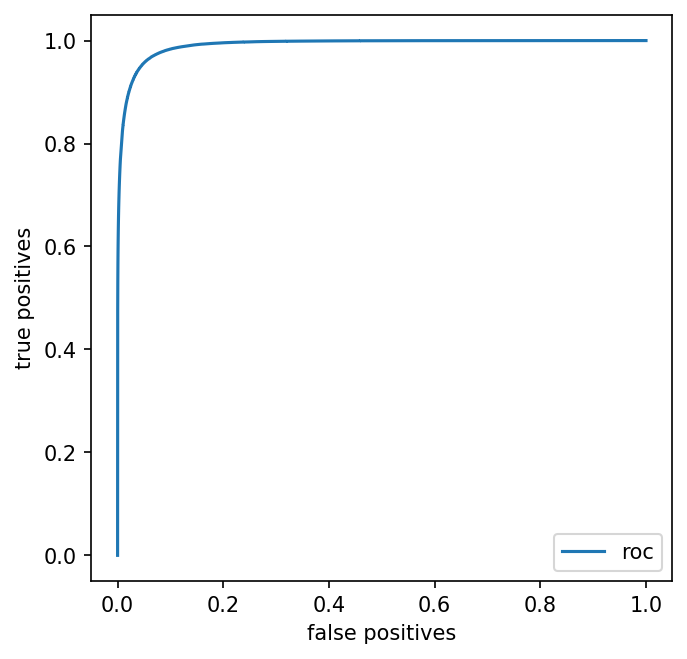

In [33]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_val,batch_size=2048)
auc = roc_auc_score(y_val, pred, sample_weight=w_val)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_val, pred, sample_weight=w_val,drop_intermediate=True)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)

plt.legend()

# AUC by eta and Et bin

In [20]:
data["y"] =  model.predict(scaler.transform(data[cols].values), batch_size=4096)

det == "EB"
ets = [0,20,40,60,80,100]
if det=="EB":
    etas = [0, 0.4,0.8, 1.2,1.479]
if det=="EE":
    etas = [1.479,1.75,2.,2.25,3]

data["eta_bin"] = pd.cut(abs(data.seed_eta), etas, labels=list(range(len(etas)-1)))
data["et_bin"] = pd.cut(data.et_seed, ets, labels=list(range(len(ets)-1)))

result =  data.groupby(["eta_bin", "et_bin"]).apply(
        lambda gr:  roc_auc_score(gr.in_scluster, gr.y, sample_weight=gr.w)
)

a = result.values.reshape((len(etas)-1,len(ets)-1))
plt.imshow(a.T)
plt.xlabel("Eta bin")
plt.ylabel("Et bin")
plt.title("AUC")
plt.colorbar()

NameError: name 'det' is not defined

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve
data["y"] =  model.predict(scaler.transform(data[cols].values), batch_size=4096)

ets = [0,20,40,60,80,100]
etas = [0, 0.4,0.8, 1.2,1.479, 1.75,2.,2.25,3]

data["eta_bin"] = pd.cut(abs(data.seed_eta), etas, labels=list(range(len(etas)-1)))
data["et_bin"] = pd.cut(data.et_seed, ets, labels=list(range(len(ets)-1)))

result =  data.groupby(["eta_bin", "et_bin"]).apply(
        lambda gr:  roc_auc_score(gr.in_scluster, gr.y, sample_weight=gr.w)
)

a = result.values.reshape((len(etas)-1,len(ets)-1))


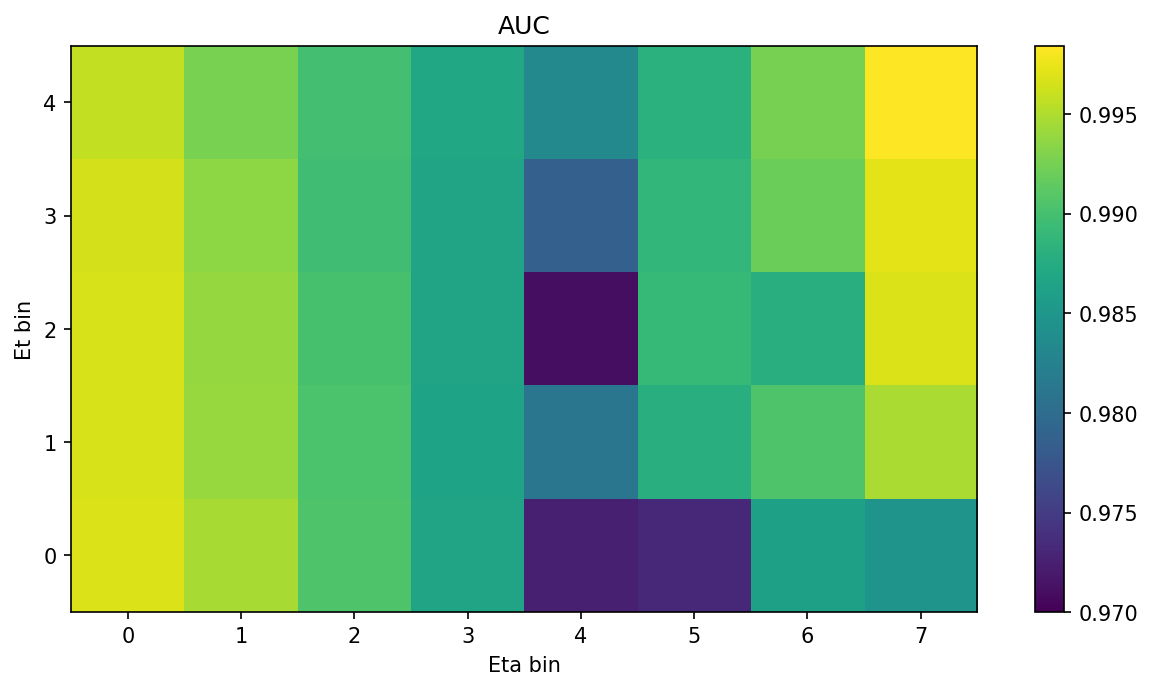

In [23]:
plt.figure(figsize=(10,5))
plt.imshow(a.T, vmin=0.970)
plt.xlabel("Eta bin")
plt.ylabel("Et bin")
plt.title("AUC")
plt.colorbar()
plt.savefig(model_dir+ "/AUC.png")

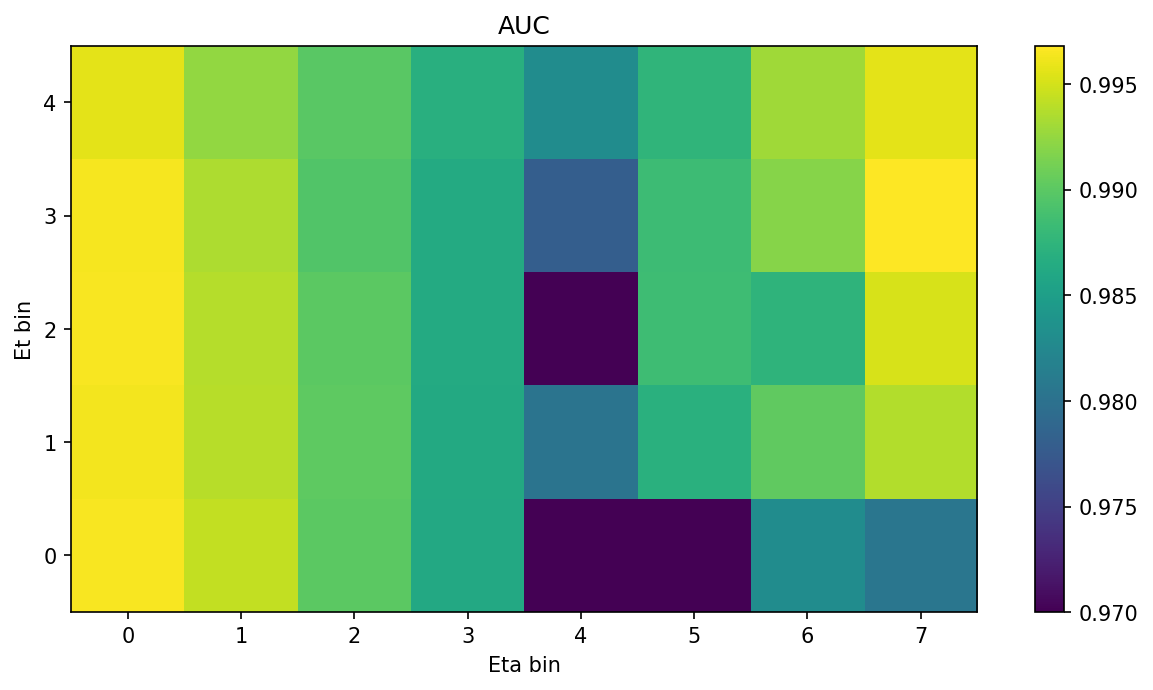

In [35]:
plt.figure(figsize=(10,5))
plt.imshow(a.T, vmin=0.970)
plt.xlabel("Eta bin")
plt.ylabel("Et bin")
plt.title("AUC")
plt.colorbar()
plt.savefig(model_dir+ "/AUC_v2.png")

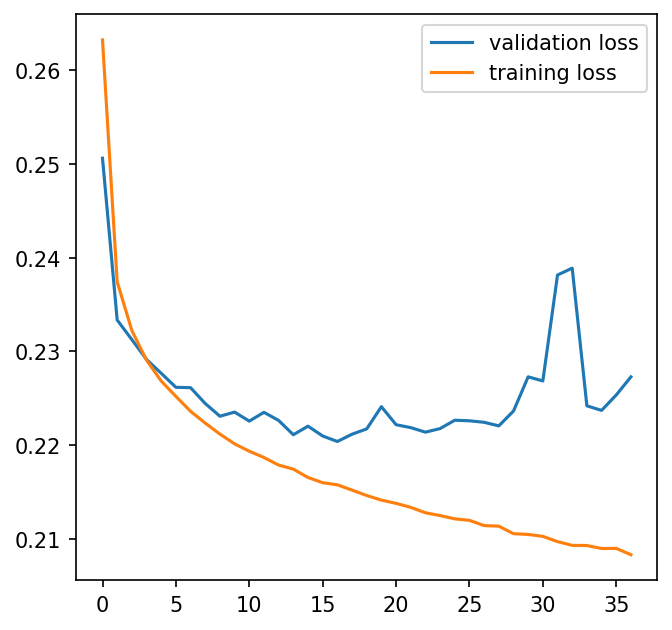

In [26]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

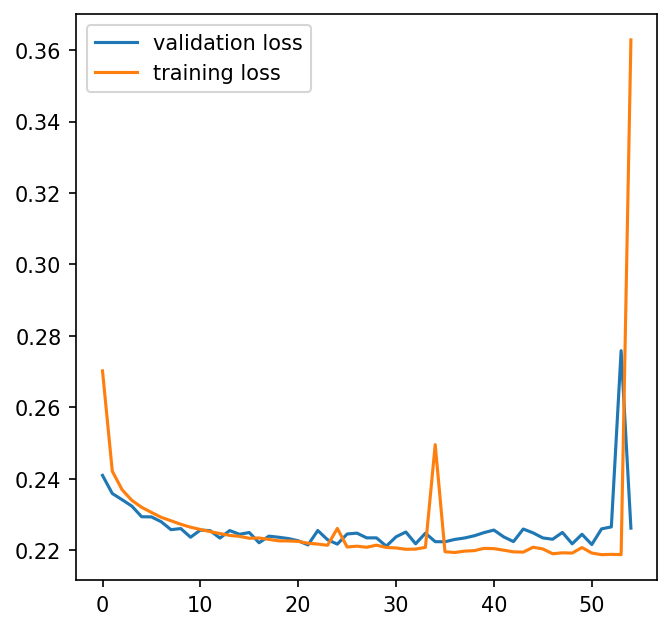

In [36]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

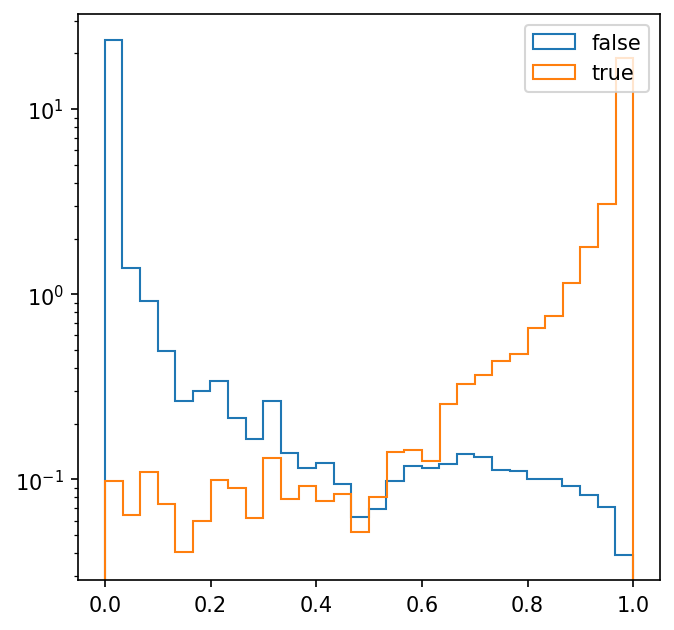

In [37]:
results = model.predict(X_val[:200000])
plt.hist(results[y_val[:200000]==0], bins=30,density=True, label="false", histtype="step")
plt.hist(results[y_val[:200000]==1], bins=30, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

In [25]:
plt.savefig(model_dir +"/output_model_v2_EE.png")

<Figure size 750x750 with 0 Axes>

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

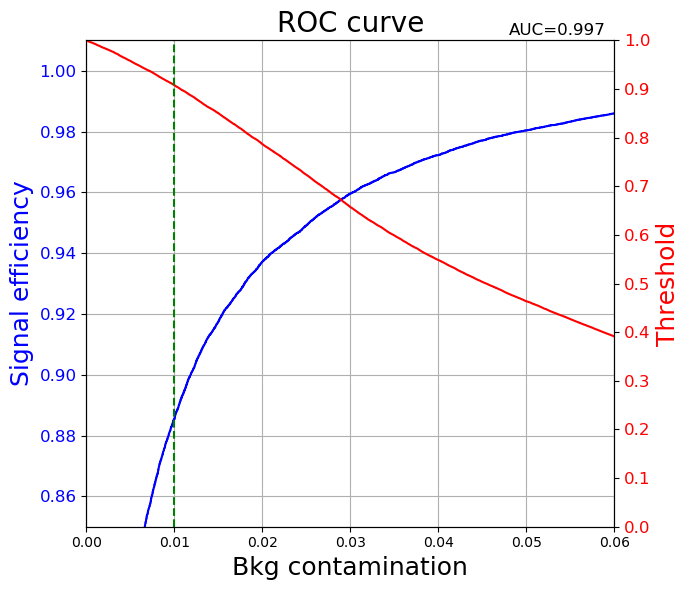

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()